In [7]:
import pandas as pd
data = pd.read_csv("query_smiles_for_tc_train_anonymized.csv",sep='\t')

In [32]:
data.head()

,Unnamed: 0,Target,Molecule_ID,Activity,SMILES
0,0,B,0,1.80,CC(C)Oc1ccccc1N2CCN(Cc3cccc(c3)C(=O)N4CCCCC4)CC2
1,1,B,1,281.50,Oc1ccccc1OCCNCc2ccccc2
2,2,B,2,83.00,Oc1ccc2CCC3C(OCCN3CCc4cccs4)c2c1
3,3,B,3,27.80,CS(=O)(=O)Nc1cc(OCCNCc2cccs2)ccc1Cl
4,4,B,4,0.21,CCCN1CCOC2C1CCc3ccc(O)cc23


In [53]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

query_mol = Chem.MolFromSmiles('OC1(CCN(CCCC(=O)c2ccc(F)cc2)CC1)c3ccc(Cl)cc3')
mols = [Chem.MolFromSmiles(s) for s in data['SMILES']]

query_fp = AllChem.GetMorganFingerprintAsBitVect(query_mol, 4, nBits = 1024) # radius = 4
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 4, nBits = 1024) for m in mols]

I don't know what radius should I set

In [54]:
TanimotoSimilarity = [DataStructs.FingerprintSimilarity(query_fp, fp) for fp in fps]

In [55]:
def convert_to_pki(affinities):
	    """Returns value in new_min to new_max scale
	
	    Parameters
	    ----------
	    affinities : np.float32 or pd.DataFrame
	        value to convert (in nanomolar)
	
	    Returns
	    ----------
	    new_val : np.float32
	        new value as pKi
	    """
	
	    if isinstance(affinities, pd.DataFrame):
	        affinities = -np.log10(affinities)
	        affinities += 9
	    elif isinstance(affinities, np.ndarray):
	        nonzeros = np.nonzero(affinities)
	        affinities[nonzeros] = -np.log10(affinities[nonzeros])
	        affinities[nonzeros] += 9
	    elif isinstance(affinities, numbers.Number):
	        affinities = 9 - np.log10(affinities)
	    else:
	        raise TypeError("only numpy ndarray and pandas dataframe types are supported. {} was found"
	                        .format(type(affinities)))
	    return affinities

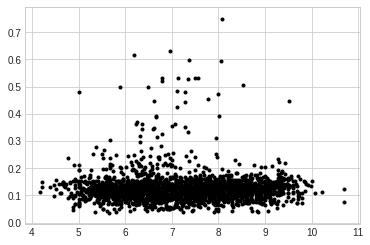

In [56]:
import numpy as np
import numbers
import matplotlib
import matplotlib.pyplot as plt

#plt.style.use('seaborn-whitegrid')
plt.scatter([convert_to_pki(a) for a in data['Activity']], TanimotoSimilarity, marker = '.', color = 'black')
#plt.scatter(data['Activity'], TanimotoSimilarity, maker = '.')
plt.show()